In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [33]:
DEVICE = 'cuda:0'
NSAMPLES = 100000
MAX_EPOCHS = 100

In [34]:
def model(z):
    grid = np.linspace(-1, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    mu = np.zeros_like(X)
    for i in range(len(z)-2):
        mu += z[i] * np.cos(X*i+i) * np.cos(Y*i)        
    return mu

def noisemodel(x, z = None, sigma = 0.5):
    n = np.random.randn(*x.shape)*sigma
    return x + n

In [35]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 3)
        self.conv2 = torch.nn.Conv2d(10, 20, 3)
        self.conv3 = torch.nn.Conv2d(20, 40, 3)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

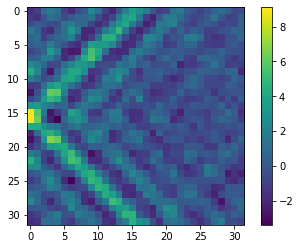

In [36]:
z0 = np.random.rand(20)
zdim = len(z0)
x0 = noisemodel(model(z0))
comb1d = [[i] for i in range(zdim)]

plt.imshow(x0)
plt.colorbar()

In [37]:
ds = swyft.MemoryCache(zdim = zdim, xshape = (32, 32))

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [38]:
re_prev = None
for r in range(1):
    td = swyft.TrainData(x0 = x0, zdim = zdim, noisehook = noisemodel, cache = ds, nsamples = NSAMPLES, threshold = 1e-4, parent = re_prev)
    ds.simulate(model)
    re = swyft.RatioEstimator(zdim, td, device = DEVICE, combinations = comb1d, head = Head)
    re.train(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [2e-3, 1e-3, 5e-4, 2.5e-4, 1.25e-4])
    re_prev = re

Constrained posterior area: 1.0
Adding 99897 new samples. Run simulator!


Simulate: 100%|██████████| 99897/99897 [04:47<00:00, 348.04it/s]


Number of output features: 160
Start training
LR iteration 0
Total epochs: 9
Validation losses: [34.85928964614868, 33.80743968486786, 33.358885407447815, 32.935760855674744, 32.41902410984039, 32.23006570339203, 32.07760453224182, 31.61633265018463, 31.691375374794006]
LR iteration 1
Total epochs: 4
Validation losses: [31.280031204223633, 30.982133746147156, 30.921125888824463, 31.239184975624084]
LR iteration 2
Total epochs: 3
Validation losses: [30.86555588245392, 30.507848620414734, 30.614598155021667]
LR iteration 3
Total epochs: 3
Validation losses: [30.531961917877197, 30.27647066116333, 30.416944980621338]
LR iteration 4
Total epochs: 5
Validation losses: [30.5582138299942, 30.430243968963623, 30.29801082611084, 30.055397987365723, 30.66536319255829]


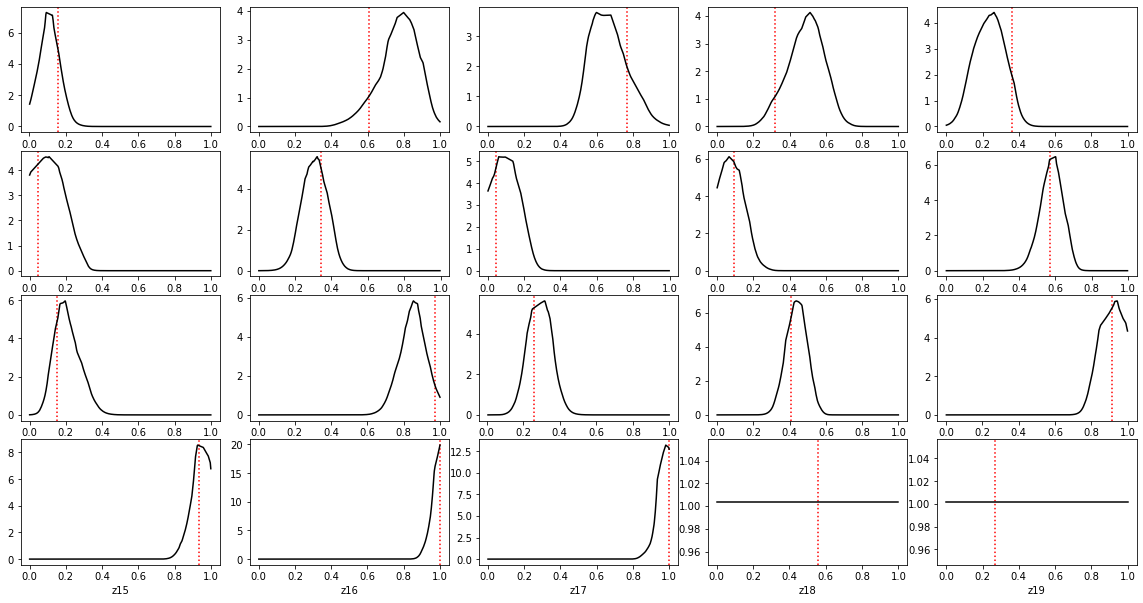

In [39]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (20, 10), ncol = 5)